In [1]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.tensorboard import SummaryWriter

In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# check GPU availability

In [3]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [30]:
class ConvNet(nn.Module):
    def __init__(self, num_class = 900):
        super(ConvNet, self).__init__()
        # 30x30
        self.layer1 = nn.Sequential(
        nn.Conv2d(5, 16, kernel_size=3),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),
        nn.Conv2d(16, 32, kernel_size=3),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),
        nn.Flatten(),
        nn.Linear(1152,900))
        
        # self.layer2 = nn.Sequential(
        # nn.Conv2d(17, 32, kernel_size=3),
        # nn.BatchNorm2d(32),
        # nn.ReLU(),
        # nn.MaxPool2d(kernel_size = 2),
        # nn.Conv2d(32, 32, kernel_size=3),
        # nn.BatchNorm2d(32),
        # nn.ReLU(),
        # nn.MaxPool2d(kernel_size = 2),
        # nn.Flatten(),
        # nn.Linear(1152,512))

        # self.feature_layers = nn.ModuleList()
        # for i in range(17):
        #     self.feature_layers.append(
        #         nn.Sequential(
        #             nn.Conv2d(1, 16, kernel_size=3),
        #             nn.BatchNorm2d(16),
        #             nn.ReLU(),
        #             nn.MaxPool2d(kernel_size=2),
        #             nn.Flatten(),
        #             nn.Linear(3136,1000),
        #             nn.Linear(1000,100)
        #         )
        #     )

        # self.featurelinear = nn.ModuleList()
        # for i in range(17):
        #     self.featurelinear.append(
        #         nn.Linear(1000,900)
        #     )
        # (1,1000) -> (1,900)

        # self.layer3 = nn.Sequential(
        # nn.Conv2d(64, 128, kernel_size=3),
        # nn.BatchNorm2d(128),
        # nn.ReLU(),
        # nn.MaxPool2d(kernel_size=2, stride=2))
        
    def forward(self, x, feature):
        main_out = self.layer1(x)
        # for i in range(17):
        #     f_i = self.feature_layers[i](feature[:,i].unsqueeze(1))
        #     main_out = torch.cat((main_out, f_i), dim=1)
        #     main_out = self.featurelinear[i](main_out)
        # feat_out = self.layer2(feature)
        # main_out = torch.cat((main_out, feat_out), dim=1)

        # main_out = self.fc(main_out)
        return nn.Sigmoid(main_out)
    
model = ConvNet().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

## Data loading

In [5]:
DATASET_PATH = 'data/uci_ml_hackathon_fire_dataset_2012-05-09_2013-01-01_10k_train.hdf5'

with h5py.File(DATASET_PATH, 'r') as f:
    train_data = {}
    for k in list(f):
        train_data[k] = f[k][:]

In [8]:
print(train_data.keys())

dict_keys(['datetime', 'land_cover', 'latitude', 'longitude', 'meteorology', 'observed', 'target'])


### Test point

In [19]:
large_fire_inds = np.where(
    (np.sum(train_data['observed'][:,0],axis=(1,2)) > 50) & 
    (np.sum(train_data['observed'][:,1],axis=(1,2)) > 50) & 
    (np.sum(train_data['observed'][:,2],axis=(1,2)) > 50) & 
    (np.sum(train_data['observed'][:,3],axis=(1,2)) > 50) & 
    (np.sum(train_data['observed'][:,4],axis=(1,2)) > 50) & 
    (np.sum(train_data['target'][:,0],axis=(1,2)) > 50) 
)[0]

In [20]:
TRAINING_POINT = large_fire_inds[0]

In [21]:
LAND_COVER_LAYER_NAME_TO_IND = {'ASP': 0, 'CBD': 1, 'CBH': 2, 'CC': 3, 'CH': 4, 'DEM': 5, 'EVT': 6, 'SLP': 16}
VEGETATION_NAME_TO_IND = {'Nodata': 0, 'Sparse': 1, 'Tree': 2, 'Shrub': 3, 'Herb': 4, 'Water': 5, 'Barren': 6, 'Developed': 7, 'Snow-Ice': 8, 'Agriculture': 9}

TOPO_NAMES = ['ASP', 'SLP', 'DEM']
VEG_NAME = 'EVT'
FUEL_NAMES = ['CBD', 'CBH', 'CC', 'CH']

In [22]:
image1 = train_data['observed'][TRAINING_POINT]
target1 = train_data['target'][TRAINING_POINT]
feature1 = train_data['land_cover'][TRAINING_POINT]

In [23]:

# temp = torch.from_numpy(image1)
# temp2 = temp[None, None,:,:]
# temp2.shape
temp = torch.from_numpy(image1)
temp2 = temp.unsqueeze(0).to(device)
temp2.shape



torch.Size([1, 5, 30, 30])

In [24]:
temp = torch.from_numpy(feature1)
tempf = temp.unsqueeze(0).to(device)
tempf.shape

torch.Size([1, 17, 30, 30])

In [33]:
output = model(temp2.float(), tempf)

In [34]:
output.shape

torch.Size([1, 900])

In [35]:
# plt.title(f'{-12 * (4-i)} hours')
test_image = output.cpu().detach().numpy()
test_image.shape

(1, 900)

In [36]:
test1 = test_image[:, :900]
# test2 = test_image[:, 900:]

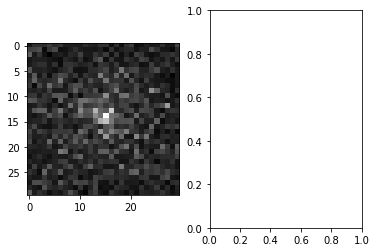

In [37]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(test1.reshape((30,30)), cmap='gray')
# ax[1].imshow(test2.reshape((30,30)), cmap='gray')
plt.show()

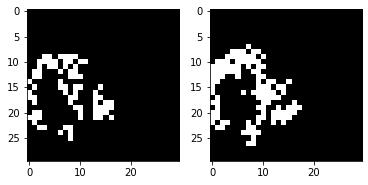

In [42]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(target1[0], cmap='gray')
ax[1].imshow(target1[1], cmap='gray')
plt.show()

## Create data loader

In [7]:
x = train_data['observed']
y = train_data['target']
f = train_data['land_cover']
f = np.nan_to_num(f)

In [8]:
ytemp = np.zeros((10000, 1800))
ytemp[:, :900] = y[:,0,...].reshape((10000,900))
ytemp[:, 900:] = y[:,1,...].reshape((10000,900))

In [9]:
y = ytemp

In [10]:
class WildFireDataset(torch.utils.data.Dataset):
    def __init__(self, x, f, y):
        self.x = x
        self.y = y
        self.f = f
    
    def __getitem__(self, ind):
        return self.x[ind],self.f[ind], self.y[ind,:900]

    def __len__(self):
        return self.x.shape[0]

In [58]:
split = np.arange(10000)
np.random.shuffle(split)
print(split)

[5100  614 5313 ... 6571  480  949]


In [72]:
train_ind = split[:8000]
valid_ind = split[8000:]

In [73]:
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_ind)
valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(valid_ind)

In [11]:
dataset = WildFireDataset(x,f,y)

In [12]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=16)

In [31]:
writer = SummaryWriter(log_dir='log/simple cnn/')

In [32]:
i = 0
for epoch in range(10):
    total_loss = 0
    for batch, (prev, feature, target) in enumerate(train_loader):
        inp = torch.autograd.Variable(torch.Tensor(prev.float())).to(device)
        # feat = torch.autograd.Variable(torch.Tensor(feature.float())).to(device)
        target = torch.autograd.Variable(torch.Tensor(target.float())).to(device)
        optimizer.zero_grad()
        out = model(inp, None)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        writer.add_scalar('Loss/train',loss.item(), i)
        i+=1
        total_loss += loss.item()
    print('iter {} finish, loss is {}'.format(epoch, total_loss))

iter 0 finish, loss is 121.00385167449713
iter 1 finish, loss is 66.74306566640735
iter 2 finish, loss is 47.043738182634115
iter 3 finish, loss is 39.031863924115896
iter 4 finish, loss is 35.03957359865308
iter 5 finish, loss is 32.738347213715315
iter 6 finish, loss is 31.275155844166875
iter 7 finish, loss is 30.27809921093285
iter 8 finish, loss is 29.56279853451997
iter 9 finish, loss is 29.028314496856183


In [64]:
writer